## Imports

In [14]:
import glob
import random
from pydub import AudioSegment
from pydub.playback import play
import numpy as np
import librosa
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


## Play random audios, extract features and plot

In [3]:
def extract_features(file_path):
    y, sr = librosa.load(file_path)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    mfccs = np.mean(mfccs.T, axis=0)
    chroma = np.mean(chroma.T, axis=0)
    spectral_contrast = np.mean(spectral_contrast.T, axis=0)
    return np.hstack([mfccs, chroma, spectral_contrast])


def plot_features(features, title):
    mfccs = features[:13]
    chroma = features[13:25]
    spectral_contrast = features[25:]
    plt.figure(figsize=(10, 4))
    
    plt.subplot(3, 1, 1)
    plt.plot(mfccs,)
    plt.title(f'MFCCs for {title}')
    plt.xlabel('Coefficients')
    plt.ylabel('Amplitude')
    
    plt.subplot(3, 1, 2)
    plt.plot(chroma)
    plt.title(f'Chroma for {title}')
    plt.xlabel('Chroma Bins')
    plt.ylabel('Amplitude')
    
    plt.subplot(3, 1, 3)
    plt.plot(spectral_contrast)
    plt.title(f'Spectral Contrast for {title}')
    plt.xlabel('Frequency Bands')
    plt.ylabel('Amplitude')
    
    plt.tight_layout()
    plt.show()

Playing and extracting features for Female Audios
Playing: C:\Users\DELL\AppData\Local\Programs\Python\Python312\Scripts\Audio_Emotion_Detection\TESS Toronto emotional speech set data\Female\pleasant_surprised\YAF_near_ps.wav


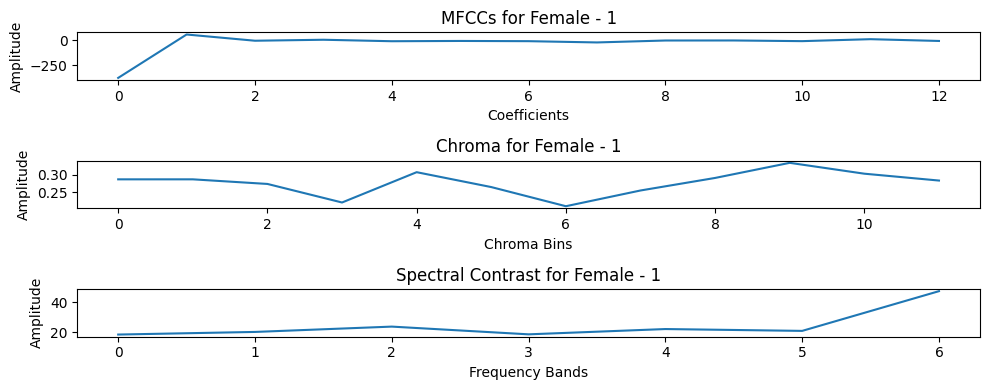

Playing: C:\Users\DELL\AppData\Local\Programs\Python\Python312\Scripts\Audio_Emotion_Detection\TESS Toronto emotional speech set data\Female\disgust\YAF_good_disgust.wav


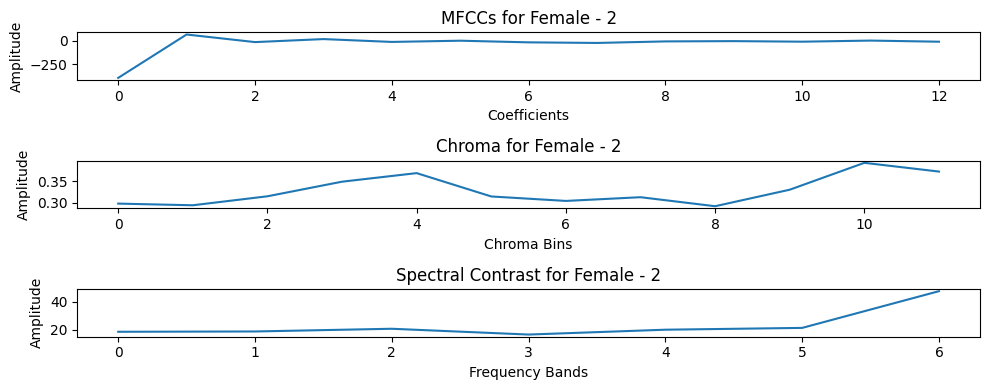

Playing and extracting features for Male Audios
Playing: C:\Users\DELL\AppData\Local\Programs\Python\Python312\Scripts\Audio_Emotion_Detection\TESS Toronto emotional speech set data\Male\neutral\OAF_time_neutral.wav


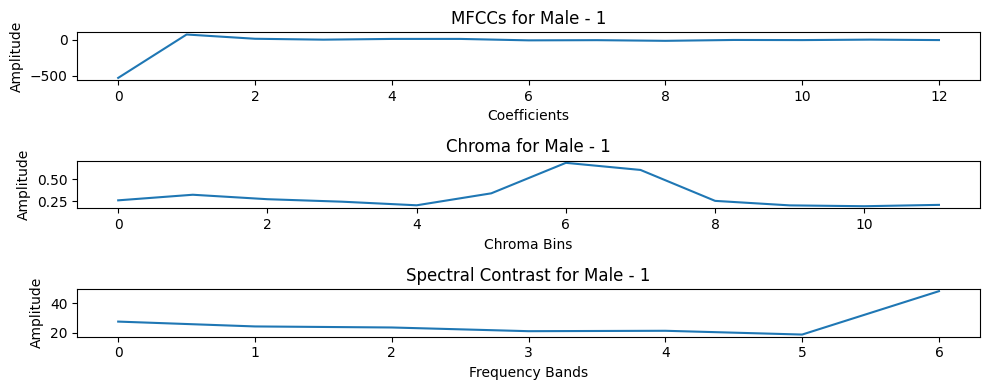

Playing: C:\Users\DELL\AppData\Local\Programs\Python\Python312\Scripts\Audio_Emotion_Detection\TESS Toronto emotional speech set data\Male\pleasant_surprised\OAF_mob_ps.wav


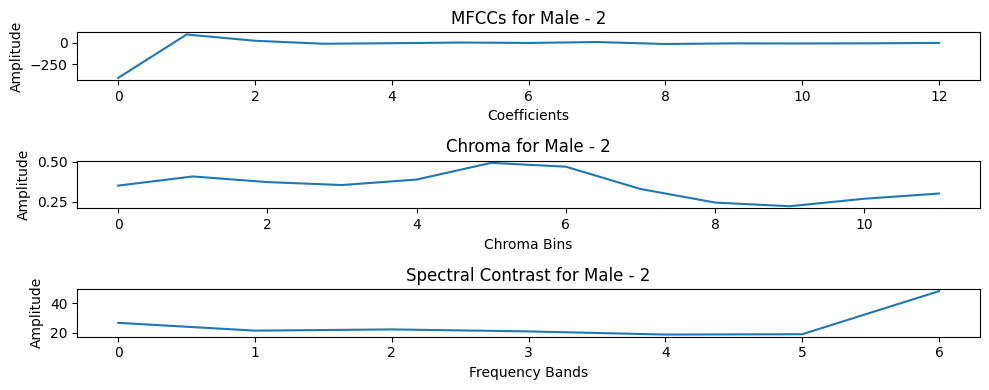

In [4]:
female_audios = glob.glob('C:\\Users\\DELL\\AppData\\Local\\Programs\\Python\\Python312\\Scripts\\Audio_Emotion_Detection\\TESS Toronto emotional speech set data\\Female\\**\\**')
male_audios = glob.glob('C:\\Users\\DELL\\AppData\\Local\\Programs\\Python\\Python312\\Scripts\\Audio_Emotion_Detection\\TESS Toronto emotional speech set data\\Male\\**\\**')

print('Playing and extracting features for Female Audios')
for i in range(2):
    female_audio = random.choice(female_audios)
    print(f"Playing: {female_audio}")
    sound = AudioSegment.from_file(female_audio)
    play(sound)
    
    features = extract_features(female_audio)
    plot_features(features, title=f'Female - {i+1}')

print('Playing and extracting features for Male Audios')
for i in range(2):
    male_audio = random.choice(male_audios)
    print(f"Playing: {male_audio}")
    sound = AudioSegment.from_file(male_audio)
    play(sound)
    
    features = extract_features(male_audio)
    plot_features(features, title=f'Male - {i+1}')


## Preparing dataset

In [5]:
def prepare_dataset(audio_files, gender_label):
    features = []
    for file_path in audio_files:
        feature_vector = extract_features(file_path)
        features.append(feature_vector)
    return pd.DataFrame(features), [gender_label] * len(audio_files)

# Gender classification dataset(0=Female, 1=Male)
female_features, female_labels = prepare_dataset(female_audios, 0)
male_features, male_labels = prepare_dataset(male_audios, 1) 

X_gender = pd.concat([female_features, male_features])
y_gender = np.array(female_labels + male_labels)


## Splitting dataset & Training gender model

In [6]:

#Splitting
X_train_gender, X_test_gender, y_train_gender, y_test_gender = train_test_split(X_gender, y_gender, test_size=0.2, random_state=42)

#Gender classification model
gender_model = RandomForestClassifier(n_estimators=100, random_state=42)
gender_model.fit(X_train_gender, y_train_gender)

RandomForestClassifier(random_state=42)

## Evaluating gender model

In [7]:
y_pred_gender = gender_model.predict(X_test_gender)
print("Gender Classification Report:")
print(classification_report(y_test_gender, y_pred_gender))

Gender Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       283
           1       1.00      1.00      1.00       277

    accuracy                           1.00       560
   macro avg       1.00      1.00      1.00       560
weighted avg       1.00      1.00      1.00       560



## Emotion detection model

In [8]:
#Mapping for emotion labels
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'pleasant_surprised', 'sad']
emotion_mapping = {emotion: idx for idx, emotion in enumerate(emotions)}

female_emotion_files = {emotion: glob.glob(f'C:\\Users\\DELL\\AppData\\Local\\Programs\\Python\\Python312\\Scripts\\Audio_Emotion_Detection\\TESS Toronto emotional speech set data\\Female\\{emotion}\\**.wav', recursive=True) for emotion in emotions}

for emotion, files in female_emotion_files.items():
    print(f"Emotion: {emotion}, Number of files: {len(files)}")

emotion_features = []
emotion_labels = []

Emotion: angry, Number of files: 199
Emotion: disgust, Number of files: 200
Emotion: fear, Number of files: 200
Emotion: happy, Number of files: 200
Emotion: neutral, Number of files: 200
Emotion: pleasant_surprised, Number of files: 200
Emotion: sad, Number of files: 200


In [9]:
for emotion, files in female_emotion_files.items():
    if files: 
        emotion_feature, emotion_label_list = prepare_dataset(files, emotion_mapping[emotion])
        emotion_features.append(emotion_feature)
        emotion_labels.extend([emotion_mapping[emotion]] * len(files))

if emotion_features:
    X_emotion = pd.concat(emotion_features)
    y_emotion = np.array(emotion_labels)
else:
    X_emotion = pd.DataFrame()
    y_emotion = np.array([])

## Training emotion model

In [10]:
if not X_emotion.empty and y_emotion.size > 0:
    X_train_emotion, X_test_emotion, y_train_emotion, y_test_emotion = train_test_split(X_emotion, y_emotion, test_size=0.2, random_state=42)

    # Train an emotion classification model
    emotion_model = RandomForestClassifier(n_estimators=100, random_state=42)
    emotion_model.fit(X_train_emotion, y_train_emotion)

    # Evaluate the emotion classification model
    y_pred_emotion = emotion_model.predict(X_test_emotion)
    print("Emotion Classification Report for Female Voices:")
    print(classification_report(y_test_emotion, y_pred_emotion))
else:
    print("No emotion samples available for training and testing.")


Emotion Classification Report for Female Voices:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        35
           1       1.00      0.98      0.99        42
           2       0.97      0.95      0.96        41
           3       0.98      0.98      0.98        44
           4       1.00      1.00      1.00        46
           5       0.98      1.00      0.99        40
           6       1.00      1.00      1.00        32

    accuracy                           0.99       280
   macro avg       0.99      0.99      0.99       280
weighted avg       0.99      0.99      0.99       280



## Testing emotion & gender of a random file

In [11]:
def classify_audio(file_path):
    feature_vector = extract_features(file_path).reshape(1, -1)
    
    gender = gender_model.predict(feature_vector)[0]
    if gender == 1:
        return "Male voice detected. Emotion detection not performed."
    
    emotion = emotion_model.predict(feature_vector)[0]
    return f"Female voice detected. Emotion: {emotion}"

# Test random audio file
test_audio = random.choice(female_audios + male_audios)
print(f"Testing with audio file: {test_audio}")
result = classify_audio(test_audio)
print(result)

Testing with audio file: C:\Users\DELL\AppData\Local\Programs\Python\Python312\Scripts\Audio_Emotion_Detection\TESS Toronto emotional speech set data\Female\neutral\YAF_third_neutral.wav
Female voice detected. Emotion: 4


## Saving both models

In [12]:
from joblib import dump
dump(gender_model, 'gender_model.joblib')
dump(emotion_model, 'emotion_model.joblib')


['emotion_model.joblib']